2025-05-18 19:16:36.672048: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 19:16:36.789991: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 19:16:36.996248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747610197.181883   55135 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747610197.215748   55135 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747610197.448440   55135 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 20/200 | D_loss: 34.2076 | G_loss: 0.4234
Epoch 40/200 | D_loss: 34.3546 | G_loss: 0.2654
Epoch 60/200 | D_loss: 34.6931 | G_loss: 0.1848
Epoch 80/200 | D_loss: 34.9469 | G_loss: 0.1408
Epoch 100/200 | D_loss: 35.1668 | G_loss: 0.1136
Epoch 120/200 | D_loss: 35.3436 | G_loss: 0.0953
Epoch 140/200 | D_loss: 35.5042 | G_loss: 0.0820
Epoch 160/200 | D_loss: 35.6362 | G_loss: 0.0720
Epoch 180/200 | D_loss: 35.7557 | G_loss: 0.0642
Epoch 200/200 | D_loss: 35.8551 | G_loss: 0.0579


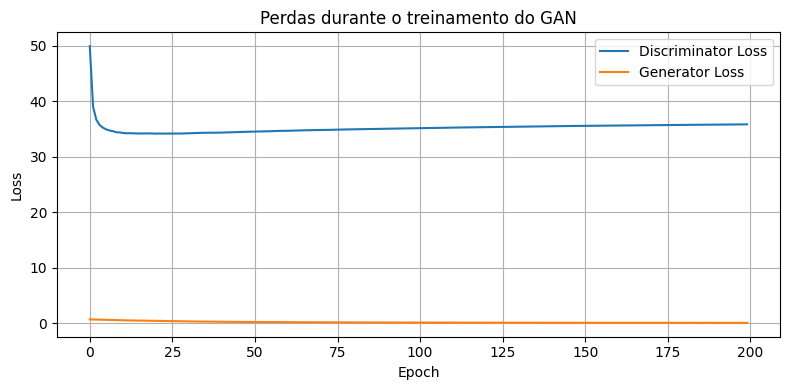

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
✅ df_generated.csv salvo com sucesso com RSSI reescalonado


In [1]:
# ✅ GAN corrigido com saída linear no Generator + Reescalonamento para RSSI

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input
import matplotlib.pyplot as plt

# ================================
# 1. Dados reais de entrada (X_real)
# ================================
df_real = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_simulated.csv")
X_real = df_real.iloc[:, :10].values.astype(np.float32)

n_features = X_real.shape[1]  # 10 WAPs
latent_dim = n_features       # 10

# ================================
# 2. Generator com saída linear
# ================================
def build_generator():
    model = Sequential([
        Input(shape=(latent_dim,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(n_features)  # saída linear
    ])
    return model

# ================================
# 3. Discriminator padrão
# ================================
def build_discriminator():
    model = Sequential([
        Input(shape=(n_features,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ================================
# 4. Compilar modelos
# ================================
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

# ================================
# 5. Loop de Treinamento GAN
# ================================
epochs = 200
batch_size = 64
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(epochs):
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))

    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# ================================
# 6. Plotar perdas
# ================================
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# 7. Gerar e salvar 40.000 vetores sintéticos com reescala
# ================================
n_generated = 40000
noise = np.random.uniform(-1, 1, size=(n_generated, latent_dim))
generated_rssi_raw = generator.predict(noise, verbose=1)

# Reescalonar saída para o intervalo [-110, -40]
min_val, max_val = -5, 6  # baseado na saída bruta inspecionada do generator
generated_rssi_scaled = (generated_rssi_raw - min_val) / (max_val - min_val)  # [0, 1]
generated_rssi = generated_rssi_scaled * 70 - 110  # [0, 1] -> [-110, -40]

columns = [f'WAP{str(i+1).zfill(3)}' for i in range(n_features)]
df_generated = pd.DataFrame(generated_rssi, columns=columns)
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("✅ df_generated.csv salvo com sucesso com RSSI reescalonado")
